In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


In [3]:
path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes


['lung_aca', 'lung_scc', 'lung_n']

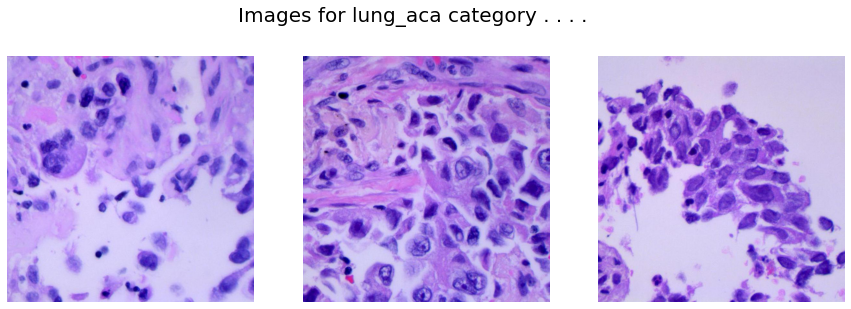

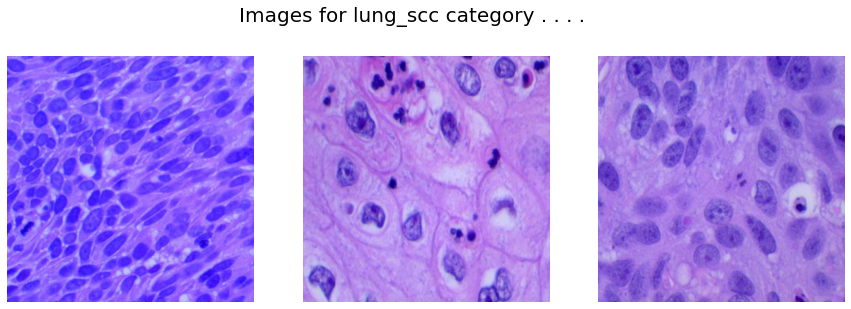

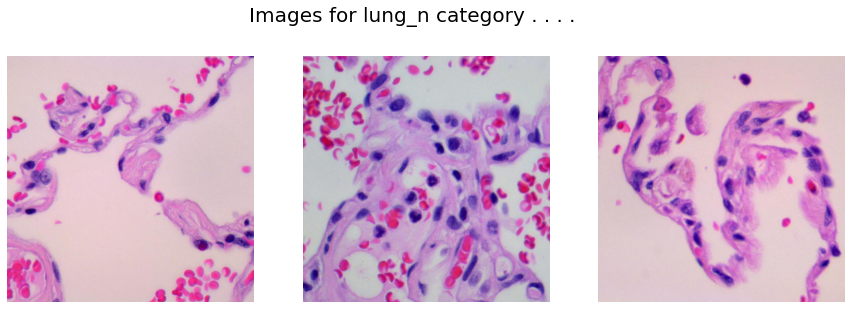

In [4]:
path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


In [5]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


In [6]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')

for image in images:
	img = cv2.imread(image)
	
	X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
	Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,test_size = SPLIT,random_state = 2022)
print(X_train.shape, X_val.shape)


(4000, 256, 256, 3) (1000, 256, 256, 3)


In [8]:
model = keras.models.Sequential([layers.Conv2D(filters=32,kernel_size=(5, 5),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3),padding='same'),layers.MaxPooling2D(2, 2),

layers.Conv2D(filters=64,kernel_size=(3, 3),activation='relu',padding='same'),layers.MaxPooling2D(2, 2),

layers.Conv2D(filters=128,kernel_size=(3, 3),activation='relu',padding='same'),layers.MaxPooling2D(2, 2),

layers.Flatten(),
layers.Dense(256, activation='relu'),
layers.BatchNormalization(),
layers.Dense(128, activation='relu'),
layers.Dropout(0.3),
layers.BatchNormalization(),
layers.Dense(3, activation='softmax')
])


2023-01-23 18:55:44.665499: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0

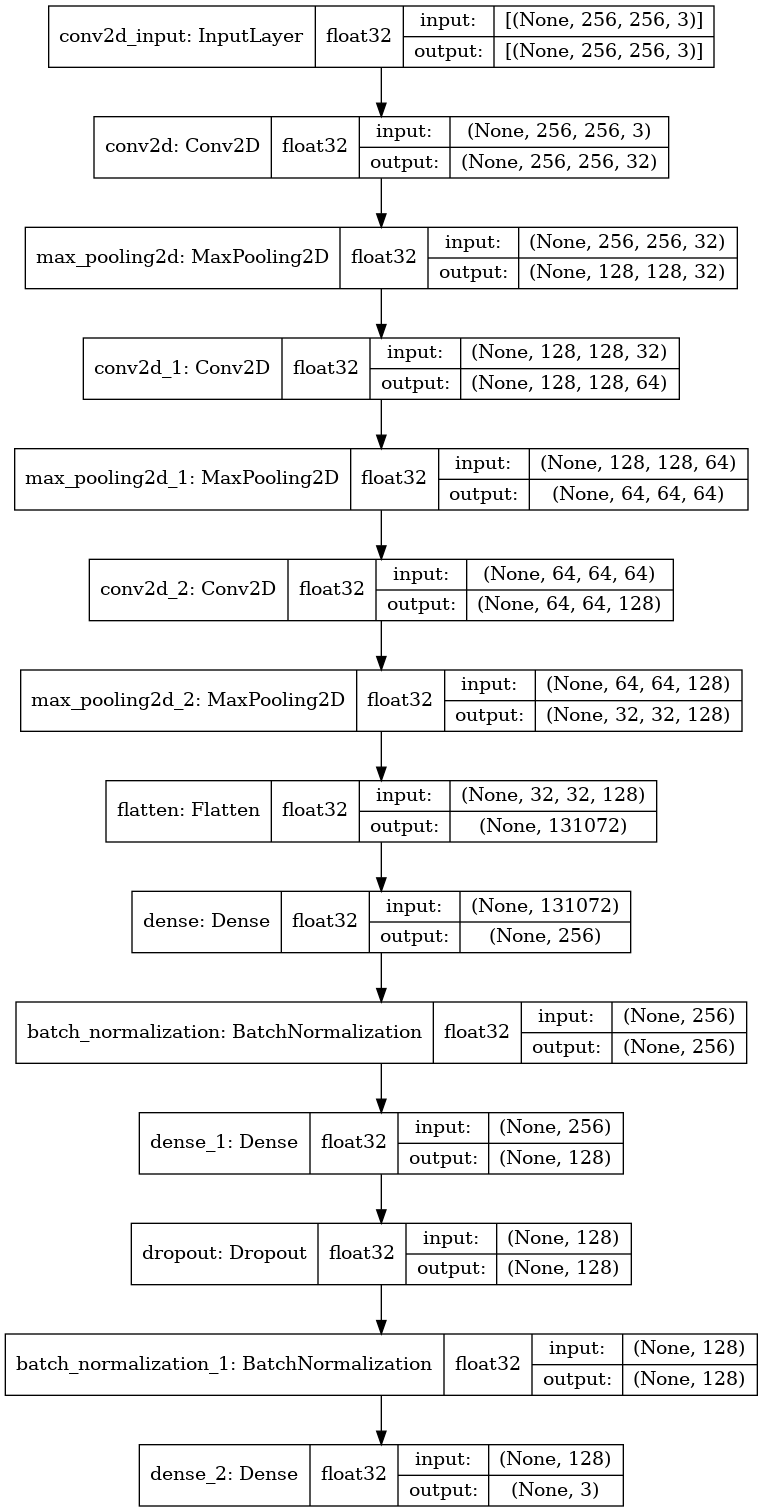

In [10]:
keras.utils.plot_model(model,show_shapes = True,show_dtype = True)


In [15]:
model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])


In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,monitor='val_accuracy',restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.5,verbose=1)


In [16]:
history = model.fit(X_train, Y_train,validation_data = (X_val, Y_val),batch_size = BATCH_SIZE,epochs = EPOCHS,verbose = 1,callbacks = [es, lr, myCallback()])


Epoch 1/10
63/63 [==============================] - 271s 4s/step - loss: 0.9902 - accuracy: 0.6323 - val_loss: 0.3750 - val_accuracy: 0.9680

 Validation accuracy has reached upto \90% so, stopping further training.


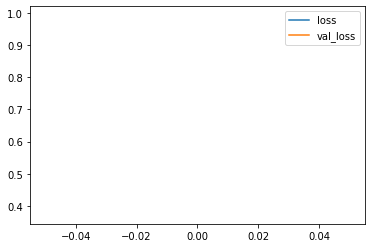

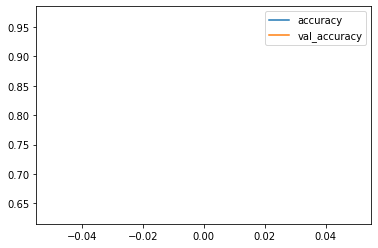

In [18]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


In [19]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


In [20]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[ 32, 968],
       [  0,   0]])

In [24]:
print(metrics.classification_report(Y_val, Y_pred))


              precision    recall  f1-score   support

           0       1.00      0.03      0.06      1000
           1       0.00      0.00      0.00         0

    accuracy                           0.03      1000
   macro avg       0.50      0.02      0.03      1000
weighted avg       1.00      0.03      0.06      1000

